# Convergence test Dynamic Power Iteration with Momentum

In [1]:
from mpi4py import MPI
from dolfinx import *
from dolfinx import mesh, fem, default_scalar_type
import numpy as np
from slepc4py   import SLEPc
from dolfinx.fem.petsc import assemble_matrix
from mshr import *
import basix, ufl, os
import time
import matplotlib.pyplot as plt
from petsc4py import PETSc
import numpy as np

In [2]:
from NeutronTransportSolver import NeutronTransportSolver

### **Unit square**

In [3]:
# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 16, 16)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('16 x 36 Unit square')
print('k_eff                                                   :', solver.eigval)
print('Number of iterations Dynamic Power Method with momentum :', solver.power_its)
print('CPU time                                                :', time1 - time0)

# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 32, 32)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('32 x 32 Unit square')
print('k_eff                                                   :', solver.eigval)
print('Number of iterations Dynamic Power Method with momentum :', solver.power_its)
print('CPU time                                                :', time1 - time0)

# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 64, 64)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('64 x 64 Unit square')
print('k_eff                                                   :', solver.eigval)
print('Number of iterations Dynamic Power Method with momentum :', solver.power_its)
print('CPU time                                                :', time1 - time0)

# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 128, 128)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('64 x 64 Unit square')
print('k_eff                                                   :', solver.eigval)
print('Number of iterations Dynamic Power Method with momentum :', solver.power_its)
print('CPU time                                                 :', time1 - time0) 

------------------------------------------------------------------------------
16 x 36 Unit square
k_eff                                                   : 0.014878728614072712
Number of iterations Dynamic Power Method with momentum : 9
CPU time                                                : 0.18372747999999994
------------------------------------------------------------------------------
32 x 32 Unit square
k_eff                                                   : 0.014985004175294135
Number of iterations Dynamic Power Method with momentum : 8
CPU time                                                : 0.44725628399999984
------------------------------------------------------------------------------
64 x 64 Unit square
k_eff                                                   : 0.01501176690389477
Number of iterations Dynamic Power Method with momentum : 6
CPU time                                                : 1.8997174480000005
------------------------------------------------------

In [4]:
# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 16, 16)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain, eigmethod='slepc')
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('16 x 36 Unit square')
print('k_eff                                                   :', 1/solver.eigval)
print('CPU time                                                :', time1 - time0)

# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 32, 32)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain, eigmethod='slepc')
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('32 x 32 Unit square')
print('k_eff                                                   :', 1/solver.eigval)
print('CPU time                                                :', time1 - time0)

# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 64, 64)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain, eigmethod='slepc')
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('64 x 64 Unit square')
print('k_eff                                                   :', 1/solver.eigval)
print('CPU time                                                :', time1 - time0)

# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 128, 128)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain, eigmethod='slepc')
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('128 x 128 Unit square')
print('k_eff                                                   :', 1/solver.eigval)
print('CPU time                                                :', time1 - time0)

aca
aca2
------------------------------------------------------------------------------
16 x 36 Unit square
k_eff                                                   : (0.014878728582821887+0j)
CPU time                                                : 0.26419145999999927
aca
aca2
------------------------------------------------------------------------------
32 x 32 Unit square
k_eff                                                   : (0.014985003900740817+0j)
CPU time                                                : 0.42209399500000444
aca
aca2
------------------------------------------------------------------------------
64 x 64 Unit square
k_eff                                                   : (0.015011766854944021+0j)
CPU time                                                : 1.3162577860000013
aca
aca2
------------------------------------------------------------------------------
128 x 128 Unit square
k_eff                                                   : (0.015018469832203181+0

aiuda

In [5]:
# Crear el dominio
domain = mesh.create_unit_square(MPI.COMM_WORLD, 128, 128)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('64 x 64 Unit square')
print('k_eff                                                   :', solver.eigval)
print('Number of iterations Dynamic Power Method with momentum :', solver.power_its)
print('CPU time                                                 :', time1 - time0) 

------------------------------------------------------------------------------
64 x 64 Unit square
k_eff                                                   : 0.015018469839922345
Number of iterations Dynamic Power Method with momentum : 6
CPU time                                                 : 37.79529930800001


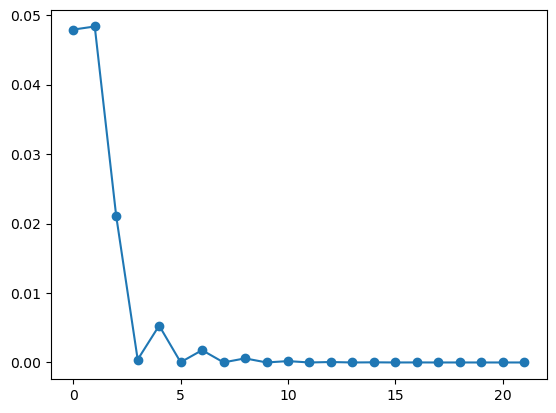

In [5]:
plt.plot(solver.power_res, '-o')

### **Unit cube**

In [9]:
# Crear el dominio
domain = mesh.create_unit_cube(MPI.COMM_WORLD, 16, 16, 16)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('16 x 16 x16 Unit cube')
print('k_eff                                                   :', solver.eigval)
print('Number of iterations Dynamic Power Method with momentum :', solver.power_its)
print('CPU time                                                :', time1 - time0)

# Crear el dominio
domain = mesh.create_unit_cube(MPI.COMM_WORLD, 32, 32, 32)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('32 x 32 x 32 Unit cube')
print('k_eff                                                   :', solver.eigval)
print('Number of iterations Dynamic Power Method with momentum :', solver.power_its)
print('CPU time                                                :', time1 - time0)


------------------------------------------------------------------------------
16 x 16 x16 Unit cube
k_eff                                                   : 0.009894914897569876
Number of iterations Dynamic Power Method with momentum : 9
CPU time                                                : 2.880569500000007
------------------------------------------------------------------------------
32 x 32 x 32 Unit cube
k_eff                                                   : 0.010013005457455607
Number of iterations Dynamic Power Method with momentum : 16
CPU time                                                : 477.05432734600004


In [10]:
# Crear el dominio
domain = mesh.create_unit_cube(MPI.COMM_WORLD, 16, 16, 16)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain, eigmethod = 'slepc')
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('16 x 36 Unit square')
print('k_eff                                                   :', 1/solver.eigval)
print('CPU time                                                :', time1 - time0)

# Crear el dominio
domain = mesh.create_unit_cube(MPI.COMM_WORLD, 32, 32, 32)

# Crear el solver y resolver 
solver = NeutronTransportSolver(domain, eigmethod = 'slepc')
time0 = time.process_time()
solver.solve()
time1 = time.process_time()

print('------------------------------------------------------------------------------')
print('32x32x32 Unit square')
print('k_eff                                                   :', 1/solver.eigval)
print('CPU time                                                :', time1 - time0)

aca
aca2
------------------------------------------------------------------------------
16 x 36 Unit square
k_eff                                                   : (0.009894914857492457+0j)
CPU time                                                : 2.9178281460000335
aca
aca2
------------------------------------------------------------------------------
32x32x32 Unit square
k_eff                                                   : (0.010013005407561839+0j)
CPU time                                                : 150.44265549199997
